<a href="https://colab.research.google.com/github/sangttruong/Cummins/blob/master/VulMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting Currencies Devaluation by Macroeconomic Indicators**
*Author: Sang Truong*

Cummins Inc., Columbus, IN, 2019

# **Section 1. Introduction**

In [0]:
# Import important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from scipy import signal
from scipy.optimize import leastsq
import statsmodels.api as sm
import statsmodels.tsa.stattools as stattools
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.tsa.statespace.sarimax as sarimax
from contextlib import contextmanager
import sys, os
from scipy import stats
from scipy.special import boxcox, inv_boxcox
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Suppressing output of pip installation
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try: yield
        finally: sys.stdout = old_stdout
            
with suppress_stdout():
  ! pip install pmdarima
  ! pip install tbats
  from pmdarima import auto_arima
  from tbats import TBATS, BATS
  drive.mount('/content/gdrive')
  path = 'gdrive/My Drive/Colab Notebooks/Vulnerability matrix/'

# Load raw data
raw2018 = pd.read_excel(path + 'raw2018.xlsx')

# Generate Deval dependent dummy variable
raw2018['Deval'] = ''
for i in range(len(raw2018)):
  if(raw2018.loc[i,'D-FX'] >= 10): raw2018.loc[i, 'Deval'] = 1
  else: raw2018.loc[i, 'Deval'] = 0

# Split data into train and test set
train_2018 = raw2018.iloc[:24]
test_2018 = raw2018.iloc[24:]

In [2]:
raw2018.head(5)

,Country,Balance,Debt,GovEff,Reserves,Misery,FXend17,FXend18,D-FX,Deval
0,Angola,-2.149,65.3,-1.03,0.122587,38.88,165.92,308.61,85.999277,1
1,Argentina,-6.260,52.6,0.16,0.080789,60.29,18.61,37.70,102.579258,1
2,Botswana,8.710,15.6,0.43,0.408013,20.86,9.83,10.73,9.155646,0
3,Brazil,-0.810,84.0,-0.29,0.183454,15.72,3.31,3.88,17.220544,1
4,China,0.440,47.8,0.42,0.251767,6.02,6.50,6.87,5.692308,0


# **Section 2. Ordinary Least Square (OLS) models**

In [0]:
def ols(y, x_train, x_test):
  # Separate y to train and test
  y_train = y.iloc[:24]
  y_test = y.iloc[24:]

  # Linear model fitting
  x_train = sm.add_constant(x_train)
  model = sm.OLS(y_train['D-FX'], x_train).fit()

  # In-sample prediction
  pred_insample = model.predict()

  # Out-of-sample prediction
  x_test = sm.add_constant(x_test)
  pred_outsample = model.get_prediction(exog=x_test)
  lower_ci, upper_ci = pred_outsample.conf_int(alpha= 0.05).T
  pred_outsample = pred_outsample.predicted_mean

  # Plot
  plt.figure(figsize=(10,5))
  plt.plot(y.iloc[:,0], y.iloc[:,1], label = 'Real')
  plt.plot(y_train.iloc[:,0], pred_insample, label = 'In-sample forecast')
  plt.plot(y_test.iloc[:,0], pred_outsample, label = 'Out-of-sample forecast')
  plt.fill_between(y_test.iloc[:,0], lower_ci, upper_ci, color='k', alpha=.15)
  plt.xticks(rotation=90)
  plt.legend()
  # plt.savefig(path + 'pred.png', quality = 100, dpi = 1000, bbox_inches="tight")
  plt.show()

  # Result summary
  print(model.summary())
  return model

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


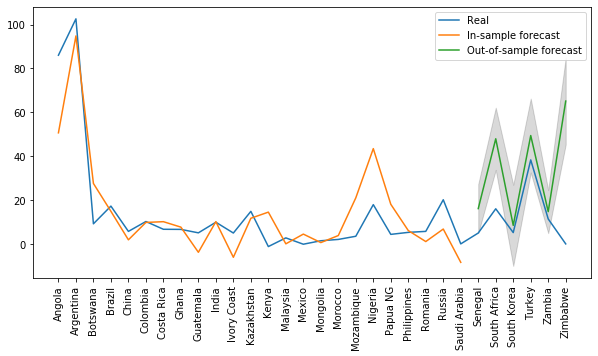

                            OLS Regression Results                            
Dep. Variable:                   D-FX   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     11.33
Date:                Mon, 18 Nov 2019   Prob (F-statistic):           4.72e-05
Time:                        14:51:31   Log-Likelihood:                -94.155
No. Observations:                  24   AIC:                             200.3
Df Residuals:                      18   BIC:                             207.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6231     10.567     -0.248      0.8

In [4]:
# OLS(D-FX ~ All 5X)

a = ols(y = raw2018[['Country', 'D-FX']],
    x_train = train_2018[['Balance', 'Debt', 'GovEff', 'Reserves', 'Misery']],
    x_test = test_2018[['Balance', 'Debt', 'GovEff', 'Reserves', 'Misery']])

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


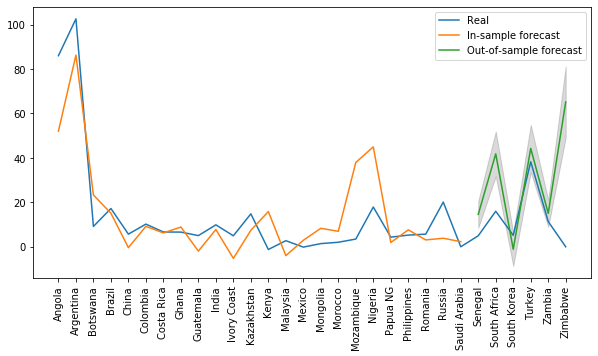

                            OLS Regression Results                            
Dep. Variable:                   D-FX   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     50.71
Date:                Mon, 18 Nov 2019   Prob (F-statistic):           3.85e-07
Time:                        14:51:31   Log-Likelihood:                -96.876
No. Observations:                  24   AIC:                             197.8
Df Residuals:                      22   BIC:                             200.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.9998      4.479     -2.232      0.0

In [5]:
# OLS(D-FX ~ Misery)

ols(y = raw2018[['Country', 'D-FX']],
    x_train = train_2018['Misery'],
    x_test = test_2018['Misery'])

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


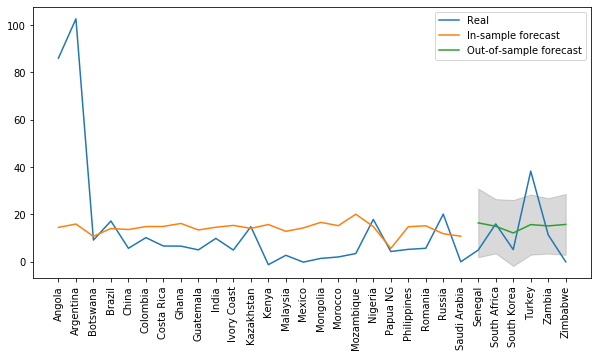

                            OLS Regression Results                            
Dep. Variable:                   D-FX   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                    0.2391
Date:                Mon, 18 Nov 2019   Prob (F-statistic):              0.630
Time:                        14:51:32   Log-Likelihood:                -111.09
No. Observations:                  24   AIC:                             226.2
Df Residuals:                      22   BIC:                             228.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.7675      5.350      2.573      0.0

In [6]:
# OLS(D-FX ~ Balance)

ols(y = raw2018[['Country', 'D-FX']],
    x_train = train_2018['Balance'],
    x_test = test_2018['Balance'])

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


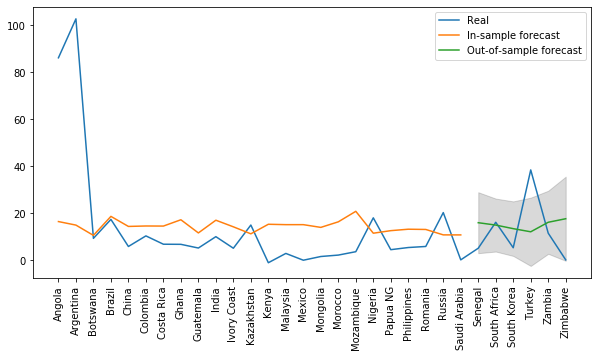

                            OLS Regression Results                            
Dep. Variable:                   D-FX   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                    0.2359
Date:                Mon, 18 Nov 2019   Prob (F-statistic):              0.632
Time:                        14:51:32   Log-Likelihood:                -111.09
No. Observations:                  24   AIC:                             226.2
Df Residuals:                      22   BIC:                             228.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5746     12.696      0.675      0.5

In [7]:
# OLS(D-FX ~ Debt)

ols(y = raw2018[['Country', 'D-FX']],
    x_train = train_2018['Debt'],
    x_test = test_2018['Debt'])

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


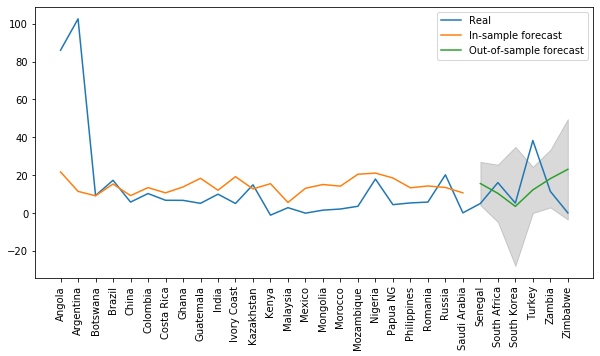

                            OLS Regression Results                            
Dep. Variable:                   D-FX   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.5707
Date:                Mon, 18 Nov 2019   Prob (F-statistic):              0.458
Time:                        14:51:32   Log-Likelihood:                -110.91
No. Observations:                  24   AIC:                             225.8
Df Residuals:                      22   BIC:                             228.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7397      5.580      2.283      0.0

In [8]:
# OLS(D-FX ~ GovEff)

ols(y = raw2018[['Country', 'D-FX']],
    x_train = train_2018['GovEff'],
    x_test = test_2018['GovEff'])

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


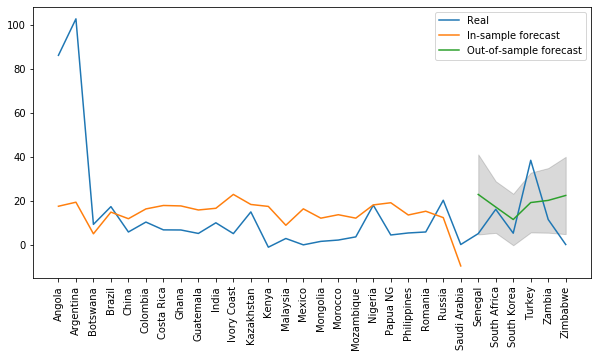

                            OLS Regression Results                            
Dep. Variable:                   D-FX   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.454
Date:                Mon, 18 Nov 2019   Prob (F-statistic):              0.241
Time:                        14:51:33   Log-Likelihood:                -110.45
No. Observations:                  24   AIC:                             224.9
Df Residuals:                      22   BIC:                             227.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.7754      8.789      2.591      0.0

In [9]:
# OLS(D-FX ~ Reserves)

ols(y = raw2018[['Country', 'D-FX']],
    x_train = train_2018['Reserves'],
    x_test = test_2018['Reserves'])

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


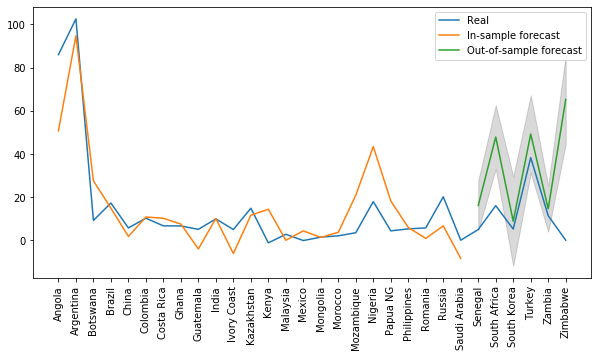

                            OLS Regression Results                            
Dep. Variable:                   D-FX   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     8.921
Date:                Mon, 18 Nov 2019   Prob (F-statistic):           0.000172
Time:                        14:51:33   Log-Likelihood:                -94.149
No. Observations:                  24   AIC:                             202.3
Df Residuals:                      17   BIC:                             210.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9732     11.522     -0.258      0.7

In [10]:
# OLS(D-FX ~ All 5X + FX17)

ols(y = raw2018[['Country', 'D-FX']],
    x_train = train_2018[['Balance', 'Debt', 'GovEff', 'Reserves', 'Misery', 'FXend17']],
    x_test = test_2018[['Balance', 'Debt', 'GovEff', 'Reserves', 'Misery', 'FXend17']])

# **Section 3. Logistic models**

# **Section 4. Forecasting Independent Indicator**

In [0]:
unemp = pd.read_excel(path + 'unemployment.xlsx')

In [17]:
unemp

,Month,Aruba,Afghanistan,Angola,Albania,Andorra,Arab World,United Arab Emirates,Argentina,Armenia,American Samoa,Antigua and Barbuda,Australia,Austria,Azerbaijan,Burundi,Belgium,Benin,Burkina Faso,Bangladesh,Bulgaria,Bahrain,"Bahamas, The",Bosnia and Herzegovina,Belarus,Belize,Bermuda,Bolivia,Brazil,Barbados,Brunei Darussalam,Bhutan,Botswana,Central African Republic,Canada,Central Europe and the Baltics,Switzerland,Channel Islands,Chile,China,...,Seychelles,Syrian Arab Republic,Turks and Caicos Islands,Chad,East Asia & Pacific (IDA & IBRD countries),Europe & Central Asia (IDA & IBRD countries),Togo,Thailand,Tajikistan,Turkmenistan,Latin America & the Caribbean (IDA & IBRD countries),Timor-Leste,Middle East & North Africa (IDA & IBRD countries),Tonga,South Asia (IDA & IBRD),Sub-Saharan Africa (IDA & IBRD countries),Trinidad and Tobago,Tunisia,Turkey,Tuvalu,Tanzania,Uganda,Ukraine,Upper middle income,Uruguay,United States,Uzbekistan,St. Vincent and the Grenadines,"Venezuela, RB",British Virgin Islands,Virgin Islands (U.S.),Vietnam,Vanuatu,World,Samoa,Kosovo,"Yemen, Rep.",South Africa,Zambia,Zimbabwe
0,1991,NaN,2.976,22.601999,16.781000,NaN,11.635213,1.632,5.440000,1.600000,NaN,NaN,9.579,3.420,0.900,1.551,6.986,1.481,2.439,2.200,12.184000,0.973,12.170,17.549999,0.600000,8.074,NaN,2.890,6.260,22.493000,4.700,1.295,13.820000,6.741,10.316,9.501198,1.777,7.588,5.230,2.400,...,NaN,6.750,NaN,0.602,2.408341,5.973976,1.844,2.630,1.900,1.400,5.985854,3.260,11.896689,1.197,2.412074,6.965240,3.439,15.074000,8.210,NaN,3.600,0.940,1.900,4.190703,12.640,6.800,1.900,19.770000,9.450000,NaN,8.720,1.962,5.995,4.394101,2.100,NaN,8.042,28.271000,18.900000,4.518
1,1992,NaN,3.173,20.924999,17.653000,NaN,12.016926,1.699,6.360000,1.800000,NaN,NaN,10.729,3.590,1.800,1.528,6.701,1.510,2.411,2.253,12.349000,1.033,14.810,18.377001,3.100000,9.617,NaN,2.881,6.420,22.940001,4.905,1.216,15.866000,6.836,11.197,9.866818,2.811,7.783,4.350,2.400,...,NaN,7.060,NaN,0.622,2.378290,6.248566,1.903,1.350,2.100,1.500,5.939283,3.316,12.041454,1.187,2.439448,6.976965,3.572,15.151000,8.509,NaN,3.451,0.920,1.900,4.215444,12.938,7.500,2.900,19.545000,7.690000,NaN,8.929,1.964,6.080,4.522017,2.354,NaN,7.981,28.608999,19.256001,4.519
2,1993,NaN,3.463,21.250000,17.681000,NaN,12.937398,1.801,10.100000,5.300000,NaN,NaN,10.874,4.250,4.500,1.605,8.077,1.552,2.568,2.377,13.031000,1.129,12.720,19.514000,8.500000,9.780,NaN,3.150,6.030,24.540001,5.175,1.304,18.583000,7.120,11.377,11.181588,3.717,8.071,4.490,2.700,...,NaN,7.400,NaN,0.700,2.676519,6.993753,2.182,1.490,6.200,1.500,5.992542,3.507,12.944427,1.300,2.582274,7.276760,3.773,15.480000,8.962,NaN,3.596,1.169,2.000,4.545440,13.377,6.900,4.900,20.266001,6.600000,NaN,9.237,1.881,6.356,4.865783,2.685,NaN,8.269,29.417000,19.700001,4.858
3,1994,NaN,3.612,21.159000,17.527000,NaN,13.097528,1.807,11.760000,6.600000,NaN,NaN,9.719,3.535,6.300,1.827,9.647,1.286,2.580,2.440,13.538000,1.135,13.830,20.395000,12.800000,11.100,NaN,3.290,6.098,22.980000,5.268,1.269,21.200001,7.237,10.395,11.290547,3.879,8.088,5.870,2.900,...,NaN,7.500,NaN,0.715,2.859228,8.452698,2.186,1.350,8.800,4.700,6.486541,3.581,13.115215,1.547,2.593682,7.338998,3.785,15.818000,8.577,NaN,3.558,1.424,2.000,4.988806,13.402,6.119,7.300,20.804001,8.560000,NaN,9.254,1.933,6.452,5.087660,2.965,NaN,8.340,29.559000,17.941999,4.960
4,1995,NaN,3.653,21.148001,17.607000,NaN,13.409279,1.800,18.799999,6.700000,NaN,NaN,8.469,4.347,7.200,1.892,9.339,1.206,2.556,2.480,13.337000,1.128,10.830,21.212000,17.700001,12.480,NaN,3.289,6.420,19.660000,5.338,1.326,21.388000,7.184,9.489,10.866934,3.327,8.069,4.700,3.000,...,NaN,7.200,NaN,0.832,2.958418,9.503092,2.183,1.100,10.300,8.300,7.724146,3.607,13.435488,1.837,2.597512,7.403208,3.772,15.880000,7.644,NaN,3.612,1.636,5.620,5.400214,13.374,5.650,7.800,20.356001,10.240000,NaN,9.235,1.943,6.503,5.239414,3.218,NaN,8.786,29.582001,16.615999,5.588
5,1996,NaN,3.621,20.066000,18.358000,NaN,12.647317,1.881,17.110001,9.300000,NaN,NaN,8.506,5.281,8.100,1.850,9.48

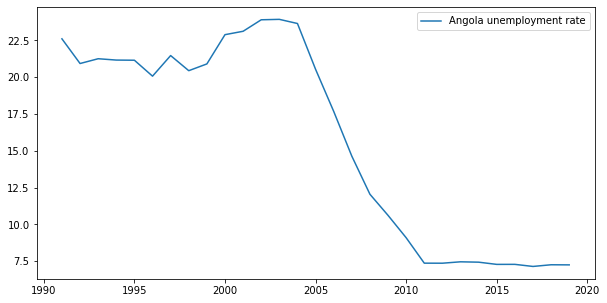

In [20]:
plt.figure(figsize=(10,5))
plt.plot(unemp['Month'], unemp['Angola'], label = 'Angola unemployment rate')
plt.legend()
plt.savefig(path + 'unempAngola.png', quality = 100, dpi = 1000)

In [0]:
def arima(i, y, train_x = None, test_x = None):
  
  # Get the name of forecast
  name = y.name

  # Separate y into train and test set
  train_y = y.iloc[:115]
  test_y = y.iloc[115:]

  # Automatically fit model to train y
  arima = auto_arima(train_y[i], exogenous = train_x,
                     start_p=0, d=None, start_q=0, max_p=5, max_d=2, max_q=5,
                     suppress_warnings = True)

  # In-sample forecast
  insample_pred = arima.predict_in_sample(exogenous = train_x)

  # Multi-step out-of-sample forecast
  outsample_pred = arima.predict(n_periods=12, exogenous = test_x, return_conf_int = True)
  lower_ci, upper_ci = outsample_pred[1].T

  # Plot
  plt.figure(figsize=(10,5))
  plt.plot(y.iloc[:,0], y[i], label = 'Real ' + name)
  plt.plot(train_y.iloc[:,0], insample_pred, label = 'In-sample forecast')
  plt.plot(test_y.iloc[:,0], outsample_pred[0], label = 'Out-of-sample forecast' )
  plt.fill_between(test_y.iloc[:,0], lower_ci, upper_ci, color='k', alpha=.15)
  plt.legend()
  # plt.savefig(path + str(i) + name +'.png', quality = 100, dpi = 1000)
  plt.show()

  # Model result
  print(arima.summary())

  return arima